# Reliability prediction of pulsar detection information

# Introduction:
Pulsars are a unique and fascinating class of objects known as neutron stars. These highly dense remnants of massive stars emit regular radio signals that can be detected from Earth. Pulsars fascinate astronomers and astrophysicists because of their potential to unlock mysteries about the fundamental properties of space-time, interstellar matter, and matter itself. But detecting pulsars requires sophisticated observational and analytical techniques. Detecting pulsars is challenging due to the presence of radio frequency interference (RFI) and noise, which makes it difficult to distinguish legitimate signals from spurious detections. We will try to predict whether the data has reference value from the data easily available in the table. The main question to be answered with this project is: Can we accurately classify pulsar candidates as real or spurious based on their observed characteristics?

### The eight continuous variables in the dataset are as follows:
* Mean of the integrated profile.
* Standard deviation of the integrated profile.
* Excess kurtosis of the integrated profile.
* Skewness of the integrated profile.
* Mean of the DM-SNR curve.
* Standard deviation of the DM-SNR curve.
* Excess kurtosis of the DM-SNR curve.
* Skewness of the DM-SNR curve.
* Class (0 for negative/spurious examples, 1 for positive/real pulsar examples)

In [19]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

### Question: How could we classify them?
The provided table presents recent observational data for pulsar candidates.  However, it is important to note that the data in the table solely comprises statistics derived from the integrated pulse profile.  Considering this limitation, the question arises: How can we predict and classify these candidates based on this dataset?

In [20]:
Problem_data<-data.frame(
    mean_pf = c(135.34231, 152.21314, 19.02311, 30.31236),
    sd_pf = c(43.51234,52.97100,28.90231,30.23142),
    exkurtosis_pf = c(1.21343043,0.43125832,6.02134123,1.82321301),
    skewness_pf = c(-0.4135212,26.5231516,43.0453823,-0.1245083)
)
Problem_data

mean_pf,sd_pf,exkurtosis_pf,skewness_pf
<dbl>,<dbl>,<dbl>,<dbl>
135.34231,43.51234,1.2134304,-0.4135212
152.21314,52.97100,0.4312583,26.5231516
19.02311,28.90231,6.0213412,43.0453823
30.31236,30.23142,1.8232130,-0.1245083


## Preliminary exploratory data analysis

In [21]:
HTRU<-read_csv("HTRU_2.csv",col_names=FALSE)
colnames(HTRU)=c("mean_pf",
                 "sd_pf",
                 "exkurtosis_pf",
                 "skewness_pf",
                 "mean_DM",
                 "sd_DM",
                 "exkurtosis_DM",
                 "skewness_DM",
                 "class")
HTRU<-HTRU|>
    mutate(class=as_factor(class))
head(HTRU)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_pf,sd_pf,exkurtosis_pf,skewness_pf,mean_DM,sd_DM,exkurtosis_DM,skewness_DM,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


By previewing the data, we can see the data is already tidy.

In [22]:
HTRU_split <- initial_split(HTRU, prop = 0.75, strata = class)  
HTRU_train <- training(HTRU_split)   
HTRU_test <- testing(HTRU_split)

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [23]:
observations<-table(HTRU_train$class)
observations


    0     1 
12192  1231 

The number of observations for each class.

In [24]:
rows_NA <- sum(!complete.cases(HTRU_train))
rows_NA

[1] 0

There is no missing value in the dataset.

In [25]:
summary(HTRU_train[c("mean_pf","sd_pf","exkurtosis_pf","skewness_pf")])

    mean_pf            sd_pf       exkurtosis_pf       skewness_pf     
 Min.   :  5.812   Min.   :24.77   Min.   :-1.87601   Min.   :-1.7819  
 1st Qu.:101.031   1st Qu.:42.39   1st Qu.: 0.02797   1st Qu.:-0.1852  
 Median :115.023   Median :46.94   Median : 0.22543   Median : 0.2002  
 Mean   :111.095   Mean   :46.55   Mean   : 0.47624   Mean   : 1.7598  
 3rd Qu.:127.086   3rd Qu.:51.01   3rd Qu.: 0.47401   3rd Qu.: 0.9252  
 Max.   :192.617   Max.   :91.81   Max.   : 8.06952   Max.   :68.1016  

Summary for each predictors.

To conduct exploratory data analysis using only training data, it's necessary to generate at least one relevant plot. One example of a useful visualization is a comparative plot that showcases the distributions of each predictor variable you intend to utilize in your analysis.

Choose the predictors.

In [26]:
HTRU_visualization<-select(HTRU_train,mean_pf,sd_pf,exkurtosis_pf,skewness_pf,class)

In [27]:
HTRU_long <- gather(HTRU_visualization, key = "vars", value = "value",-class)
head(HTRU_long)

class,vars,value
<fct>,<chr>,<dbl>
0,mean_pf,140.56250
0,mean_pf,102.50781
0,mean_pf,103.01562
0,mean_pf,136.75000
0,mean_pf,88.72656
0,mean_pf,93.57031


Visualizing variables by class profile.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



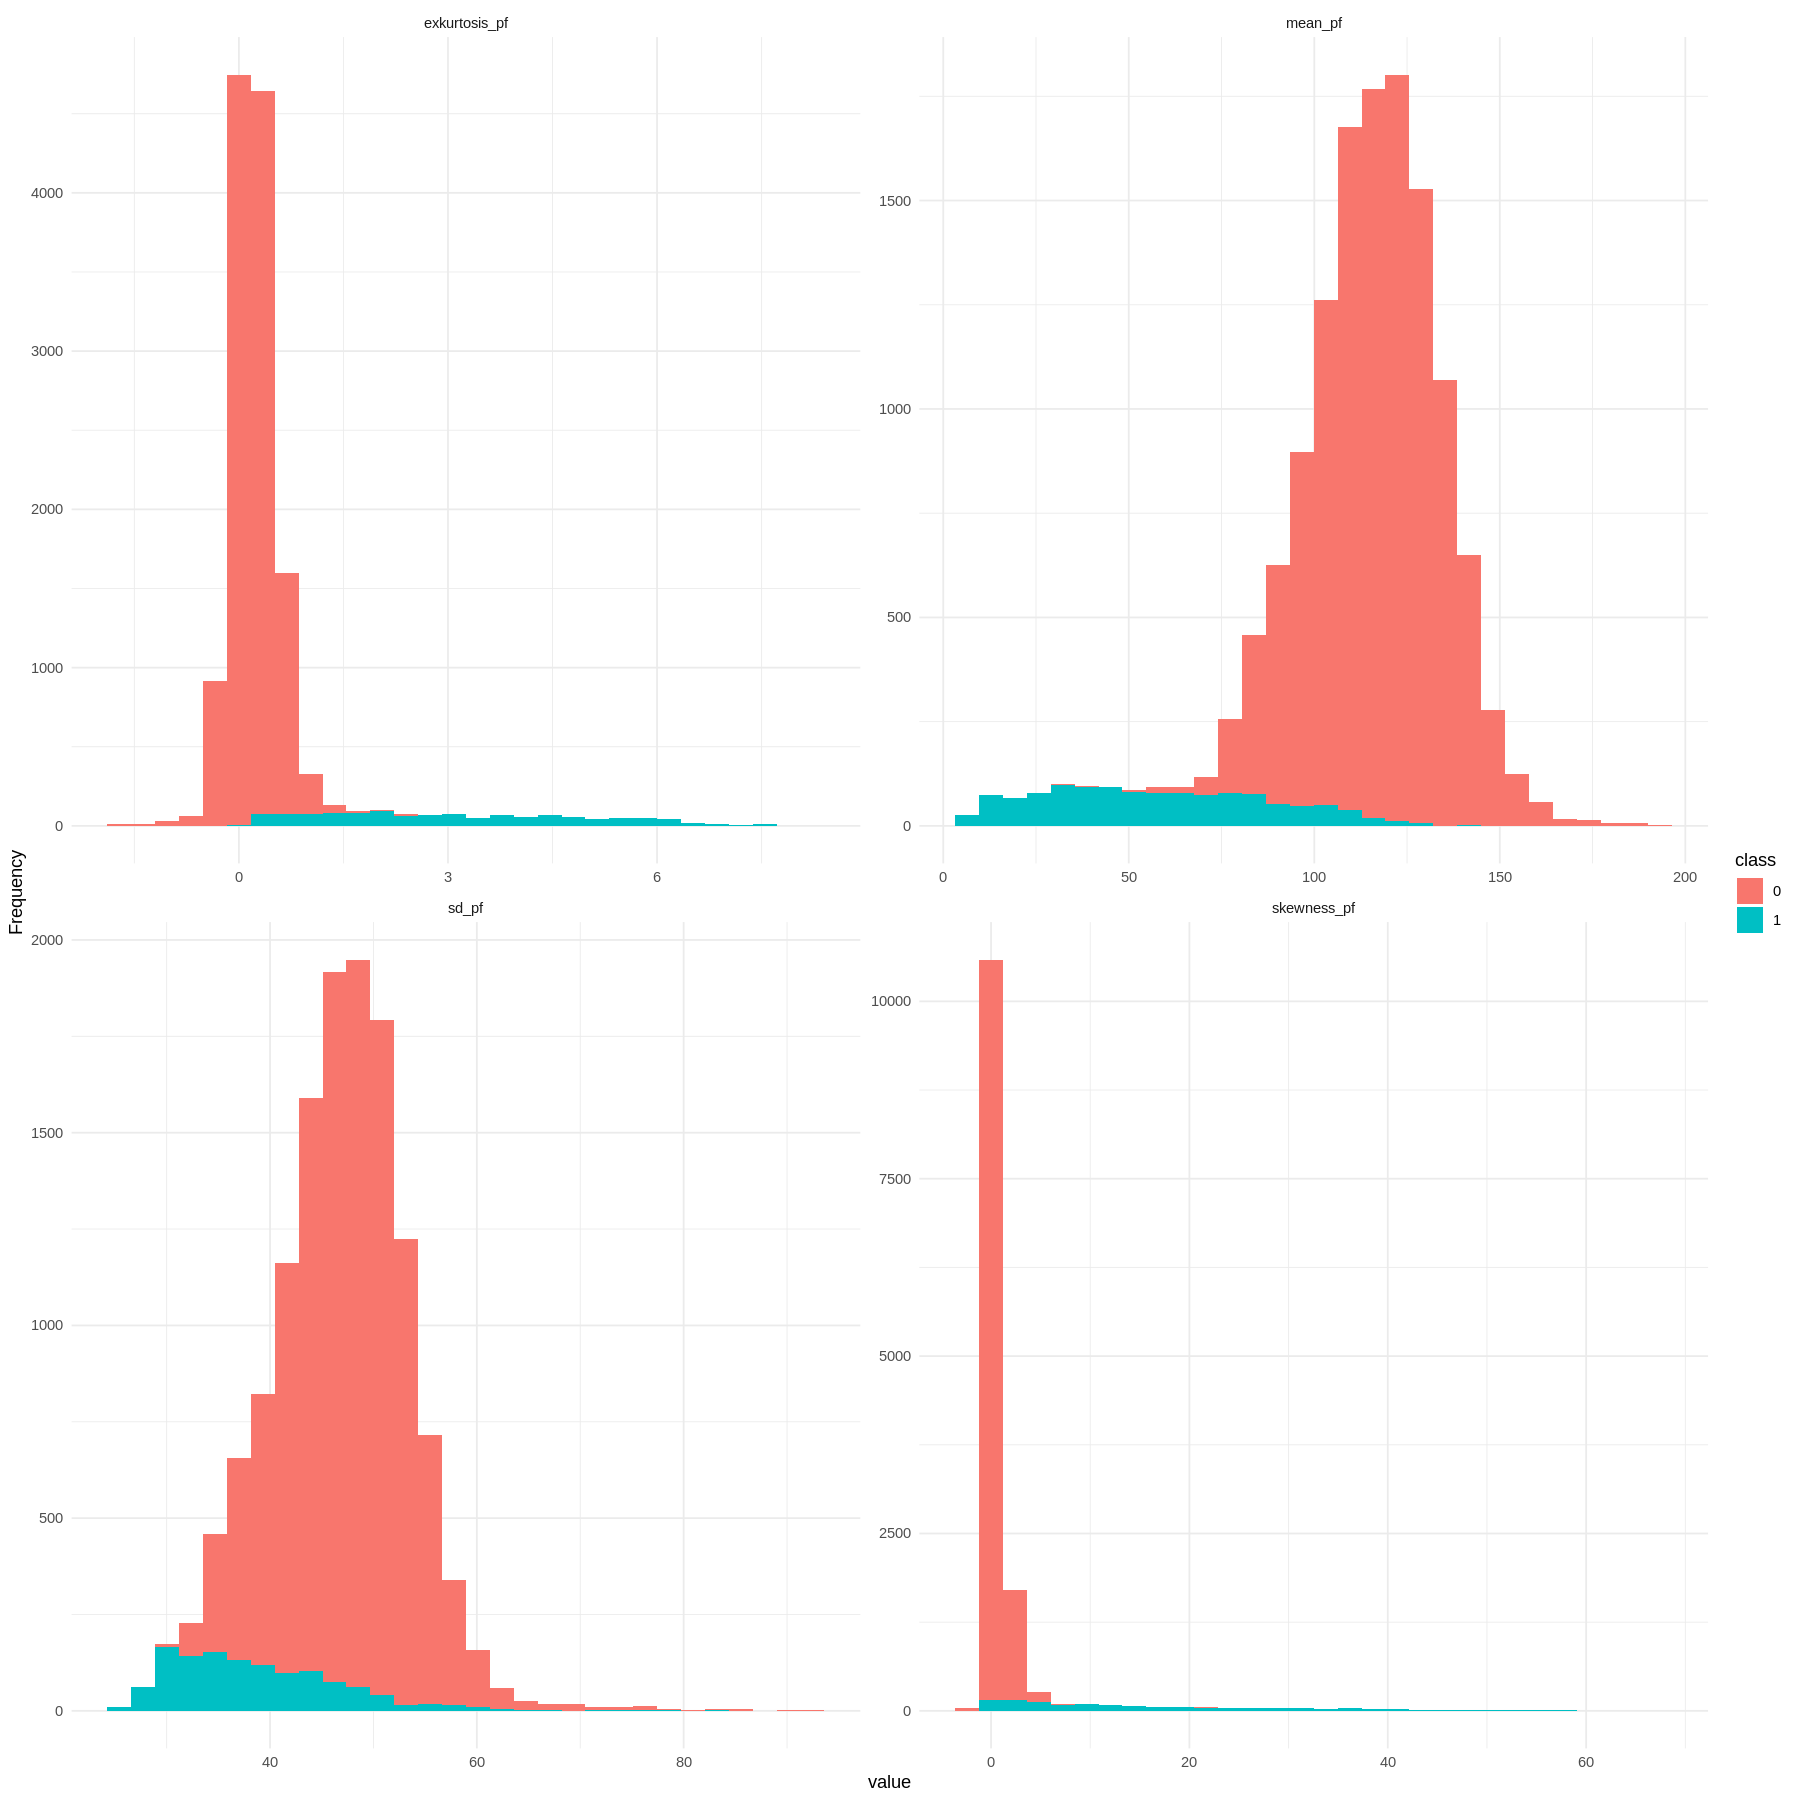

In [28]:
options(repr.plot.width = 15, repr.plot.height = 15)
HTRU_plot<-ggplot(HTRU_long,aes(x=value,fill=class))+
    geom_histogram()+
    facet_wrap(~ vars, scales = "free") +
    xlab("value")+
    ylab("Frequency")+
    theme(text = element_text(size = 30))+
    theme_minimal()
HTRU_plot

# Methods

All eight predictor variables in the dataset are correlated with predictions. However, the first four variables are derived from comprehensive pulse profiles (folded profiles) and hold greater relevance to the project's objective.

One effective approach to visualize the results is by employing scatter plot matrices or paired plots through the ggplot2 function. These plots allow us to observe the relationships between predictor variables of each type (true pulsar and pseudo pulsar) and their respective distributions. Such visualizations facilitate the identification of patterns, correlations, or distinctions in the distribution across different classes. Ultimately, they enable us to discern genuine pulsars from spurious ones.

Recipe:

In [29]:
HTRU_recipe <- recipe(class ~ mean_pf + sd_pf+ exkurtosis_pf + skewness_pf , data = HTRU_train) |>
    step_scale(mean_pf,sd_pf,exkurtosis_pf,skewness_pf) |>
    step_center(mean_pf,sd_pf,exkurtosis_pf,skewness_pf)
HTRU_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for mean_pf, sd_pf, exkurtosis_pf, skewness_pf
Centering for mean_pf, sd_pf, exkurtosis_pf, skewness_pf

Model:

In [30]:
knn_tune<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [31]:
HTRU_vfold <- vfold_cv(HTRU_train, v = 10, strata = class)
HTRU_results <- workflow() |>
       add_recipe(HTRU_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = HTRU_vfold, grid = 10) |>
       collect_metrics()
HTRU_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9655812,10,0.0016770009,Preprocessor1_Model01
2,roc_auc,binary,0.9216780,10,0.0056733719,Preprocessor1_Model01
3,accuracy,binary,0.9764583,10,0.0011972596,Preprocessor1_Model02
3,roc_auc,binary,0.9322235,10,0.0058470552,Preprocessor1_Model02
5,accuracy,binary,0.9786184,10,0.0008544911,Preprocessor1_Model03
5,roc_auc,binary,0.9388459,10,0.0066524056,Preprocessor1_Model03
6,accuracy,binary,0.9786184,10,0.0008544911,Preprocessor1_Model04
6,roc_auc,binary,0.9405247,10,0.0062191447,Preprocessor1_Model04
7,accuracy,binary,0.9789911,10,0.0005756048,Preprocessor1_Model05


Plot the accuray for different K neighbors:

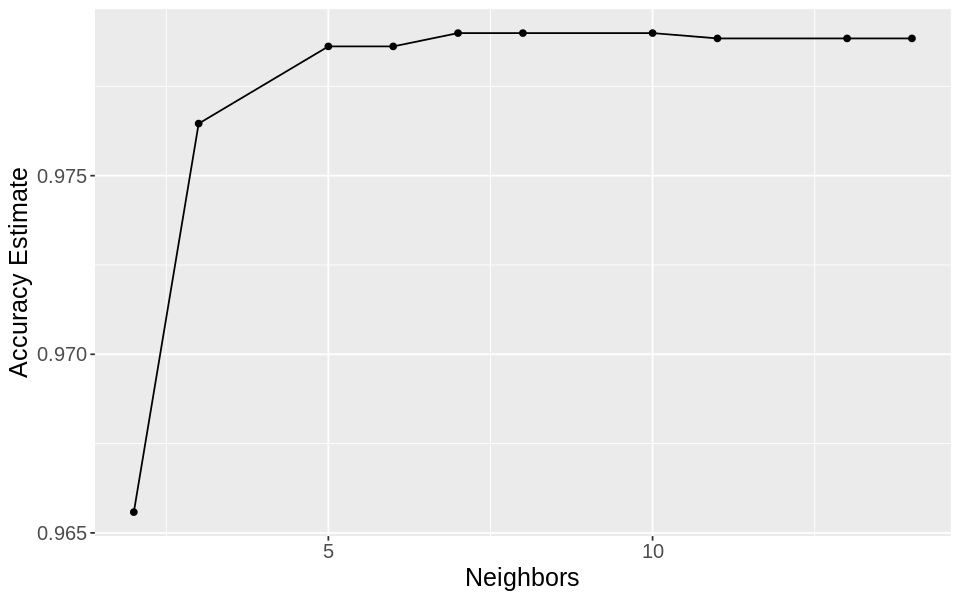

In [32]:
options(repr.plot.width = 8, repr.plot.height = 5)
accuracy<-HTRU_results|>
    filter(.metric=="accuracy")
accuracy_plot<-ggplot(accuracy,aes(x=neighbors,y=mean))+
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))
accuracy_plot

In [33]:
K_min <- accuracy |>
    arrange(desc(mean)) |> 
    slice(1)|>
    pull(neighbors)
K_min

[1] 10

The result indicates that K=10 provide the best accuracy.

In [34]:
HTRU_best_spec<-nearest_neighbor(weight_func="rectangular", neighbors=K_min)|>
    set_engine("kknn")|>
    set_mode("classification")

HTRU_fit<-workflow()|>
    add_recipe(HTRU_recipe)|>
    add_model(HTRU_best_spec)|>
    fit(data=HTRU_train)

HTRU_summary <- HTRU_fit |>
           predict(HTRU_test) |>
           bind_cols(HTRU_test)|>
           metrics(truth=class,estimate=.pred_class)
HTRU_summary   

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9792179
kap,binary,0.8680492


From the table above, the model provides a relatively high accuracy (=97.9%) for prediction.

The next step involves predicting outcomes based on the data provided in the question.

In [35]:
HTRU_prediction<-HTRU_fit|>
    predict(Problem_data)|>
    bind_cols(Problem_data)
HTRU_prediction

.pred_class,mean_pf,sd_pf,exkurtosis_pf,skewness_pf
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,135.34231,43.51234,1.2134304,-0.4135212
0,152.21314,52.97100,0.4312583,26.5231516
1,19.02311,28.90231,6.0213412,43.0453823
0,30.31236,30.23142,1.8232130,-0.1245083


By the prediction above, it indicates the only the third observation of pulsar is qualified. The third onservation is classified as 1, while the rest are not.

# Discussion

### Expected outcomes and significance

By leveraging machine learning algorithms and curated data sets, we anticipate a seamless differentiation between genuine and fabricated data.  The accurate classification of pulsar data holds immense importance in expediting the analysis of extensive pulsar investigations.  Through the automation of this classification process, astronomers and researchers can direct their efforts towards studying authentic pulsars, optimizing telescope resources, and enhancing our comprehension of space-time, the interstellar medium, and the fundamental properties of matter.

### Limitations and further questions

There still exists some limitations:

* The prediction model can not obtain thresholds for each variable for data classification.

* The classification model is sentitive to outliers, which may lead to error prediction.

To inprove our model in the future, we can:

* Applying the classification models with varying levels of accuracy to distinguish between different types of pulsars.

* Validating and generalizing the classification models by applying them to additional celestial object detection datasets.

* Analyzing the data that are classified as 0 to explore some useful information.